**Github:**

**Problem and Data Description**

The purpose of this challenge is to utilize Natural Language Processing to determine whether a tweet contains information about a real world disaster or not. The tweets will be classified based on binary classification, with 1 being a real world disaster and 0 not being a disaster.

The Dataset contains 3 files: the training file, the testing file, and a sample submission file. Both the training and testing file contain the labels to identify each tweet seperately, but the training file includes a 'target' label, containing 1 or 0, in order to train the model on what a 1 and 0 look like for each tweet in order to build an accurate model.

**Library Installation**

In [3]:
!pip install -q wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import string
from collections import defaultdict
from IPython.display import display
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

**File Implementation Using Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/NLP_Disaster_Tweets/'

try:
    train_df = pd.read_csv(folder_path + "train.csv")
    test_df = pd.read_csv(folder_path + "test.csv")
    submission_df = pd.read_csv(folder_path + "sample_submission.csv")
    print("--- Training Data ---")
    print(f"Shape: {train_df.shape}")
    print("\nColumns and Data Types:")
    train_df.info()
    print("\nFirst 5 rows:")
    display(train_df.head())

    print("\n--- Test Data ---")
    print(f"Shape: {test_df.shape}")
    print("\nFirst 5 rows:")
    display(test_df.head())

    print("\n--- Submission Format ---")
    display(submission_df.head())

except FileNotFoundError as e:
    print("---------------------------------------------------------------------------")
    print(f"ERROR: A data file was not found. {e}")
    print(f"Please make sure the folder path is correct: '{folder_path}'")
    print("And that 'train.csv', 'test.csv', and 'sample_submission.csv' are inside it.")
    print("---------------------------------------------------------------------------")

Mounted at /content/drive
--- Training Data ---
Shape: (7613, 5)

Columns and Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB

First 5 rows:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



--- Test Data ---
Shape: (3263, 4)

First 5 rows:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan



--- Submission Format ---


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


**Exploratory Data Analysis (EDA)**

While identifiying the target variable in the data, I found the data set to balanced, which reduced the amount of balancing of classes I need to do. In addition, I used word clouds to identify any patterns between the tweets within the training data. From doing this, I was able to tell which cloud was from each classification quite easily, as the non-disaster tweets used more slang terms that were not found in the disaster tweets, and the disaster tweets contained more threating words associated with disasters, such as fire, police, and storm.

As the tweets were from social media, there were many instances of words such as HTML tags, punctuation, and urls, which required some cleaning of the data. In order to clean the data, I removed any punctuation, HTML tags, urls, special characters or emojis, as well as converting every letter to lowercase for simplicity of the model.

**Plan for analysis:** Based on my EDA, my plan for analysis is to convert the cleaned text to numberical format using tokenizer and padding from the Keras library, as this allows the neural network to understand the data better. For my model architecture, I will use a sequential neural network with a bidirectional long short term memory network. The purpose of using this method is due to it being one of the best methods for text formatted data as it can remember information in long sequences. Next, I will train the model based on the training data given for the kaggle competition. From this, I will evaulate and tune the model but manipulating the hyperparameters.

**Model Architecture:** For this project, I chose to use a Bidirectional LSTM. One of the reasons why I chose this this is because LSTMs are based on processing sequences and using memory cells to maintain context when analyzing an entire sequence, which helps with more complex sentences. In addition, using a bidirectional LSTM utilizes the model reading the sentence from left to right as well as from right to left, then concaterize the two to give a better understanding of each work in the sentence. Within my architecture I utilized 6 different layers, with the bidirectional LSTM being the main layer. I use an embedding layer to convert the integer sequences to vectors. Next, I used GlobalMaxPool1D, which reduces the sequence output into a single vector. A dropout layer was used to regulate and prevent overfitting of the data. I also used a Dense input layer with reLU to learn non-linear combinations of the features, as well as a Dense output layer, which utilizes a single neuroon with a sigmoid activation function to classify the output as either 0 or 1 for the binary classification.

Not Disaster (0): 4342 tweets (57.03%)
Disaster (1): 3271 tweets (42.97%)


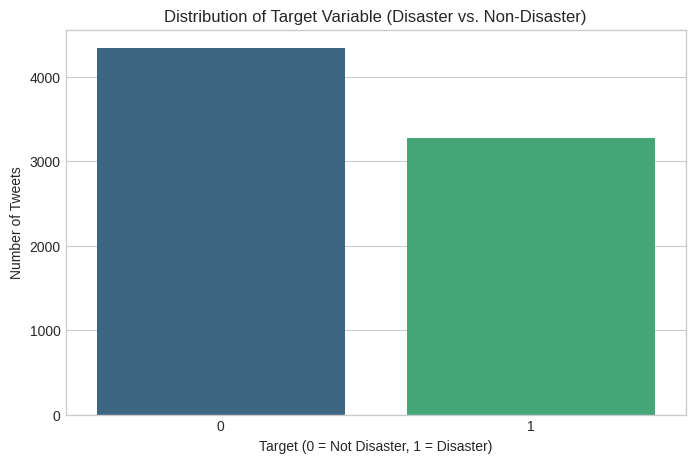

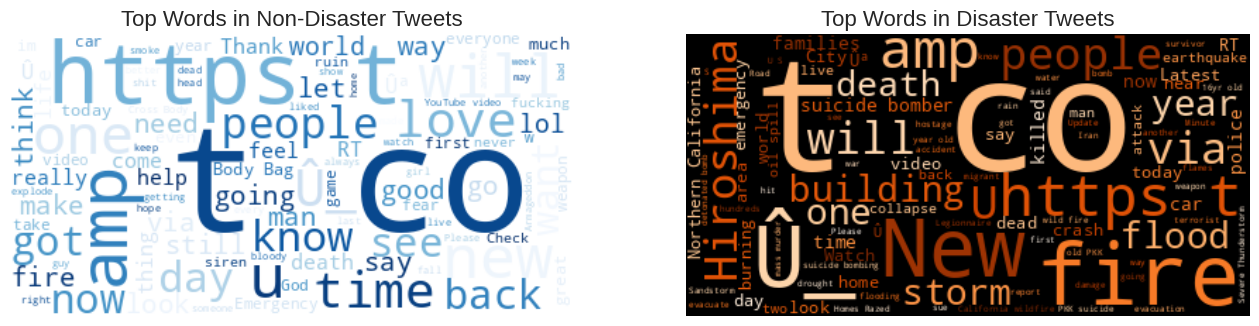

--- Sample of Cleaned Text ---


,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


Original Text:
 our deeds are the reason of this earthquake may allah forgive us all

Tokenized Sequence:
 [110, 4382, 22, 2, 821, 6, 19, 237, 124, 1539, 4383, 67, 39]

Padded Sequence (Shape: (7613, 50)):
 [ 110 4382   22    2  821    6   19  237  124 1539 4383   67   39    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,382,977 (5.28 MB)

 Trainable params: 1,382,977 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Target variable and balance inspection
if 'train_df' in locals():
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(8, 5))
    sns.countplot(x='target', data=train_df, palette='viridis', hue='target', legend=False) # Updated to address FutureWarning
    plt.title('Distribution of Target Variable (Disaster vs. Non-Disaster)')
    plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
    plt.ylabel('Number of Tweets')
    disaster_count = train_df['target'].value_counts()
    print(f"Not Disaster (0): {disaster_count[0]} tweets ({disaster_count[0]/len(train_df):.2%})")
    print(f"Disaster (1): {disaster_count[1]} tweets ({disaster_count[1]/len(train_df):.2%})")
    plt.show()

# Word cloud visualization

if 'train_df' in locals():
    stopwords = set(STOPWORDS)

    # Word cloud for non-disaster tweets
    non_disaster_text = " ".join(tweet for tweet in train_df[train_df['target'] == 0]['text'])
    wordcloud_non_disaster = WordCloud(stopwords=stopwords, background_color="white", colormap='Blues', max_words=100).generate(non_disaster_text)

    # Word cloud for disaster tweets
    disaster_text = " ".join(tweet for tweet in train_df[train_df['target'] == 1]['text'])
    wordcloud_disaster = WordCloud(stopwords=stopwords, background_color="black", colormap='Oranges', max_words=100).generate(disaster_text)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.imshow(wordcloud_non_disaster, interpolation='bilinear')
    ax1.set_title('Top Words in Non-Disaster Tweets', fontsize=16)
    ax1.axis("off")

    ax2.imshow(wordcloud_disaster, interpolation='bilinear')
    ax2.set_title('Top Words in Disaster Tweets', fontsize=16)
    ax2.axis("off")

    plt.show()

# Data cleaning
def clean_text(text):
    """
    Cleans raw text by removing URLs, HTML, punctuation, and converting to lowercase.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

if 'train_df' in locals():
    # Apply the cleaning function to both train and test data
    train_df['cleaned_text'] = train_df['text'].apply(clean_text)
    test_df['cleaned_text'] = test_df['text'].apply(clean_text)

    print("--- Sample of Cleaned Text ---")
    display(train_df[['text', 'cleaned_text']].head())

# Preprocessing
if 'train_df' in locals():
    # Parameters for tokenization and padding
    VOCAB_SIZE = 10000  # Number of unique words to keep
    MAX_LEN = 50       # Max length of sequences
    EMBEDDING_DIM = 128 # Dimension of the word vectors

    # Tokenization
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>') # OOV = Out of Vocabulary token
    tokenizer.fit_on_texts(train_df['cleaned_text'])

    # Convert text to sequences of integers
    train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
    test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

    # Padding
    train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

    print("Original Text:\n", train_df['cleaned_text'][0])
    print("\nTokenized Sequence:\n", train_sequences[0])
    print("\nPadded Sequence (Shape: {}):\n".format(train_padded.shape), train_padded[0])

    # Prepare labels
    labels = train_df['target'].values



if 'train_df' in locals():
    model = Sequential([
        Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_shape=(MAX_LEN,)),
        Bidirectional(LSTM(64, return_sequences=True)), # Using 64 LSTM units
        GlobalMaxPool1D(),
        Dense(32, activation='relu'),
        Dropout(0.5), # 50% dropout rate
        Dense(1, activation='sigmoid') # Output layer
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()

**Results and Analysis**

**Techniques To Improve Training:** I used two different techniques to improve the training: early stopping and learning rate reduction. Utilizing early stopping allows for the training process to stop if the loss of validation does not improve after over a certain number of epochs, which can save time and prevent overfitting. For learning rate reduction, I used ReduceLROnPlateau, which automatically reduces the learning rate if the validation set of the model becomes stagnate.

Training set shape: (6471, 50)
Validation set shape: (1142, 50)
Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6270 - loss: 0.6466 - val_accuracy: 0.7968 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8457 - loss: 0.3787 - val_accuracy: 0.7995 - val_loss: 0.4624 - learning_rate: 0.0010
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9126 - loss: 0.2363 - val_accuracy: 0.7872 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9511 - loss: 0.1467 - val_accuracy: 0.7750 - val_loss: 0.7009 - learning_rate: 2.0000e-04


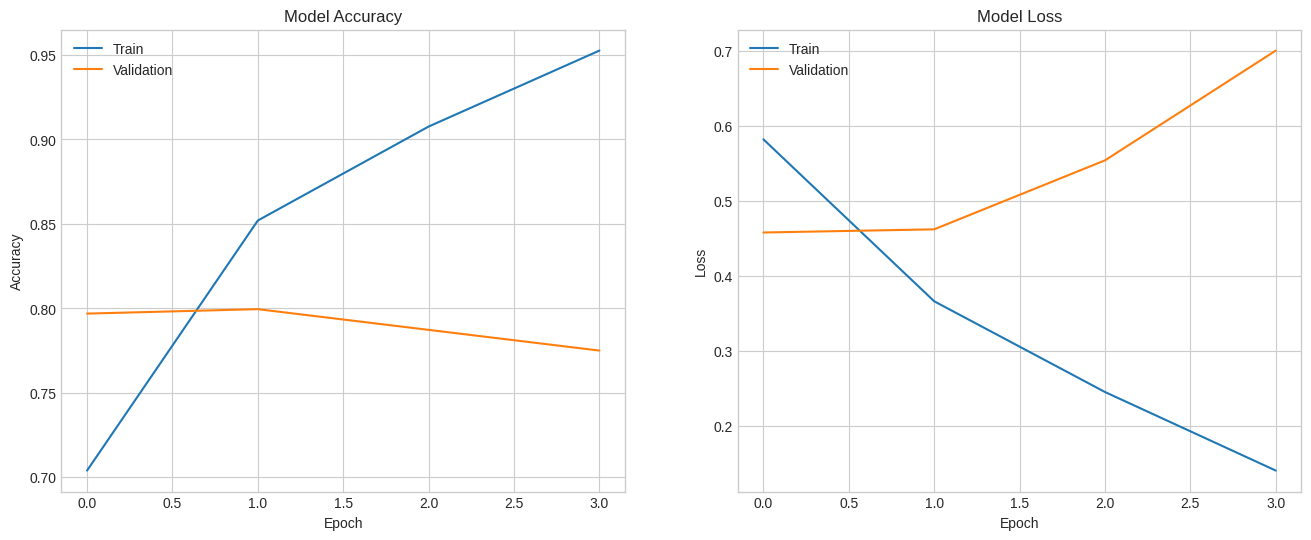

In [6]:
if 'train_df' in locals():
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_padded, labels, test_size=0.15, random_state=42)

    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        batch_size=32,
        callbacks=[early_stopping, reduce_lr])

if 'history' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot of training and validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)


    # Plot of training and validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.show()

**Analysis of Results:** Based on the accuracy of the training increasing steadily and the validation accuracy plateuing, it tells me that the model is learning the generalizable patterns. However, there was some overfitting due to the validation accuracy decreasing slightly, as well as the training accuracy increasing rapidly after the first epoch. As for the model loss curve, the use of ReduceLROnPlateau worked well for this model as the model understood that the validation loss was decreasing rapidly, and it automatically reduced the learning rate before epoch 4. In addition, using EarlyStopping in the code allowed the model to stop training after 4 epochs, and restored the model to the best state, which was epoch 1.

**Conclusion**

Overall, the model's best performance was during Epoch 1, with a validation accuracy of 78.9% and a validation loss of 0.46. Based on this, the chosen bidirectional LSTM achritecture worked well for this data, as it was able to learn the patterns of diaster related language sufficiently. However, the model did begin to rapidly overfit after the first Epoch. This was clearly seen by the seperation between the training and validation curves in the both graphs. The gap indicates that the model began memorizing instead of learning, which reduces the usability of the model overall. In addition, the Early stopping technique was utilized well, as the model understood the validation loss decrease, and stopped training after Epoch 4.

The things that worked best this project was the use of the bidirectional LSTM architecture and custom word embeddings, which is relflected in the high accuracy of Epoch 1. the use of EarlyStopping also reduced the overall overfitting of model. The things that did not work well and were the likely cause of overfitting was the training being overdone. The model learned quick enough in Epoch 1 and 2, that after Epoch 3, everything was being overfit and memorized. In addition, although the model utilized a dropout layer to minimize overfitting, the parameters of the layer needed to be finetuned in order to have a larger impact.

In the future, one thing that could improve the performance of the model is to use GloVe or fastText for the embedding layer. As these are pretrained text datasets, they have a better understanding of English sentence strucutre, and would possibly prevent overfitting. Other improvements that could be made would be increasing the dropout rate and adding kernel regularizers. As mentioned before, increasing the performance of the dropout layer would reduce overfitting of the model, and one way to do this could be using an additional dropout layer, or bumping up the rate from 50% to 60%. Furthermore, kernel regularizers could reduce the data from being overfit by pentalizing larger weights in the model.

In [8]:
# Kaggle Submission File

if 'model' in locals():
    # Make predictions on the test set
    test_predictions = model.predict(test_padded)

    # Convert probabilities to binary predictions (0 or 1)
    test_predictions = (test_predictions > 0.5).astype(int).flatten()

    # Create submission DataFrame
    submission_df['target'] = test_predictions
    display(submission_df.head())

    # Save to CSV
    submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
